## 8.3 오토인코더를 활용한 주가 데이터 생성

* 주가 수익률 데이터와 비슷한 패턴을 가진 데이터를 만드는 방법, 압축된 정보를 새로운 특성으로 활용하는 방법
* 오토인코더
> 인코더 : 입력값으로 전달받은 특성 데이터를 낮은 차원으로 변환

> 디코더 : 낮은 차원에서 원본 입력값을 예측

In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


1. Raw 데이터 불러오기
2. 로그 수익률 데이터 가공하기
3. 훈련, 테스트 데이터셋 분리하기
4. 학습에 용이하도록 데이터 정규화하기

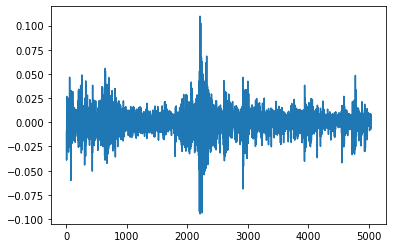

In [3]:
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 200

import pandas as pd
path = 'data/ch08/s&p500.csv'
snp500_df = pd.read_csv(path,usecols=['Adj Close'])  # 수정 종가 컬럼만 불러옴
snp500_df['pct_change'] = snp500_df['Adj Close'].pct_change()  # pct_change() 호출
snp500_df['log_ret'] = np.log(snp500_df['Adj Close']) - np.log(snp500_df['Adj Close'].shift(1)) # 종가 - 전일 종가 로 로그 수익률 계산

snp500_df['log_ret'].plot()

* 그래프 그리는 함수 정의

In [5]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 20))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [4]:
scaler = MinMaxScaler()
# 이미지정한 window 길이 간격으로 한 칸씩 이동하면서 데이터 구간을 나눠준다. (슬라이딩 윈도우)
# 그 후 MinMaxScaler로 최대-최소 정규화 한다
x_train = np.array([scaler.fit_transform(snp500_df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in range(window_length+1,len(snp500_df['log_ret']))])
x_train = x_train[:-test_samples]
x_test = x_train[-test_samples:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("테스트 데이터 비중: {}%".format((test_samples/len(x_train))*100))

테스트 데이터 비중: 4.146796599626788%


### 8.3.2 모델구조
* 다층 퍼셉트론 오토인코더
> 입력층은 10개의 입력을 받고 중앙의 은닉층은 3개의 차원으로 데이터를 압축하며, 마지막 출력층에서 다시 10개의 출력층으로 구성 (319p)

In [6]:
x_train_sample = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sample = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))
# "encoded"는 input데이터를 encode로 압축한다.
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded"는 압축된 데이터로 input 데이터를 최대한 표현한다.
decoded = Dense(window_length, activation='sigmoid')(encoded)

# 2개의 모델이 있다.
# 하나는 인풋데이터를 인코더 디코더를 통해 인풋값을 예측하는 모델.
autoencoder = Model(input_window, decoded)
# 다른 하나는 인풋데이터를 인코더 디코더로 압축하는 모델.
encoder = Model(input_window, encoded)

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_sample, x_train_sample,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_sample, x_test_sample))

decoded_stocks = autoencoder.predict(x_test_sample)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 33        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 34ms/step - loss: 0.7175 - val_loss: 0.7168
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.7155 - val_loss: 0.7148
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.7136 - val_loss: 0.7129
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.7118 - val_loss: 0.7112

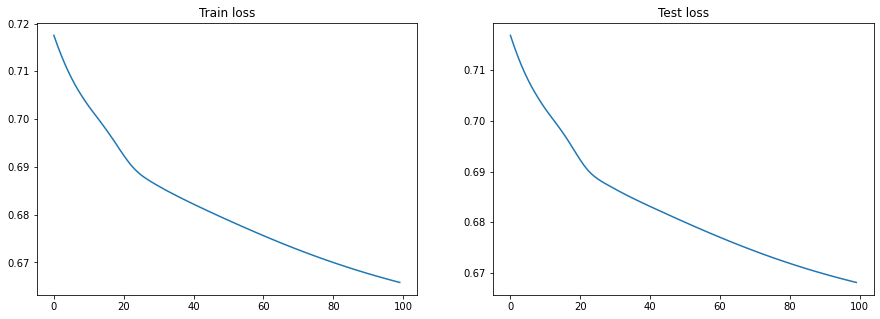

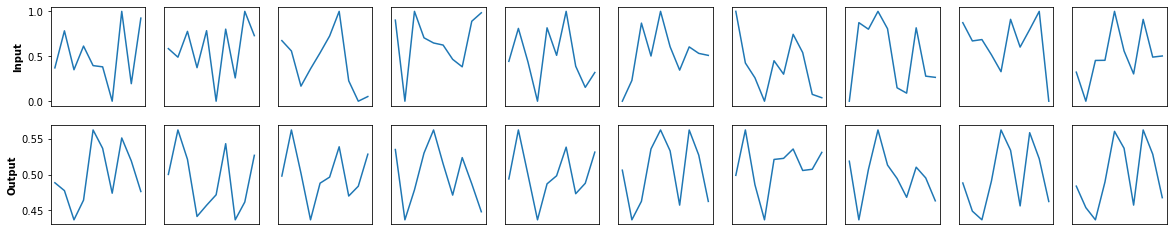

In [7]:
plot_history(history)
plot_examples(x_test_sample, decoded_stocks)

* 다층 퍼셉트론 모델에 배치층을 추가한 구조
* 앞선 모델과 비슷하지만 인코더에는 차원 축소층, 디코더에는 차원 확장층이 한개 씩 추가되며, 공통적으로 배치 정규화층을 추가 구성함 320p

In [8]:
x_train_sample = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sample = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_sample, x_train_sample,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_sample, x_test_sample))

decoded_stocks = autoencoder.predict(x_test_sample)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

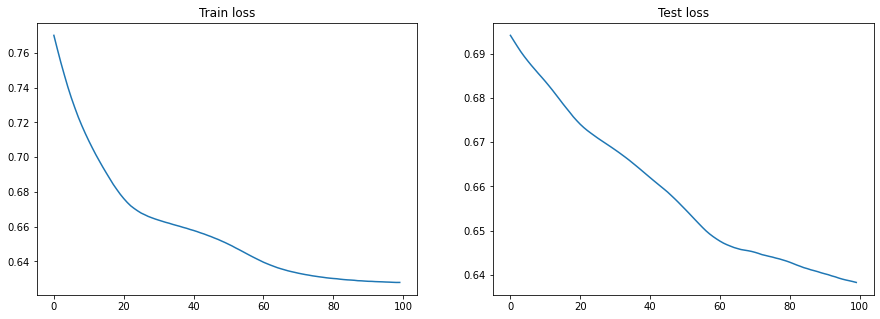

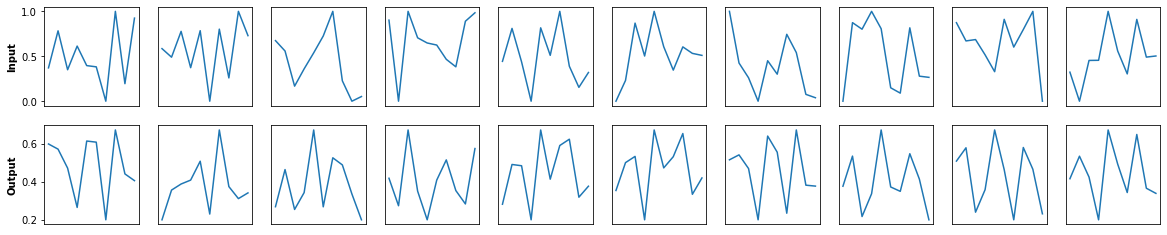

In [9]:
plot_history(history)
plot_examples(x_test_sample, decoded_stocks)

* 1D Convolutional autoencoder

In [10]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 6, 1)            

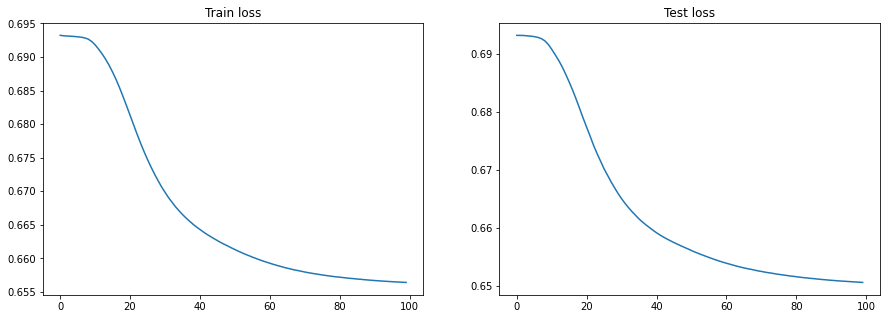

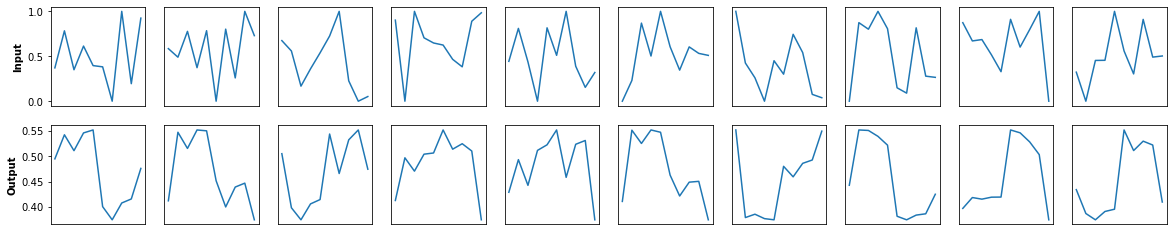

In [11]:
plot_history(history)
plot_examples(x_test, decoded_stocks)

* LSTM (recurrent neural networks) autoencoder

In [11]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 1s 202ms/step - loss: 1.2735 - val_loss: 1.2644
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 1.2201 - val_loss: 1.2137
Epoch 3/100
5/5 [==============================] - 0s 13ms

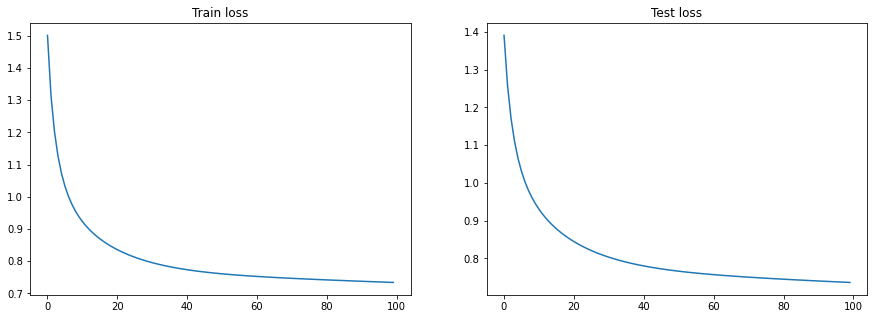

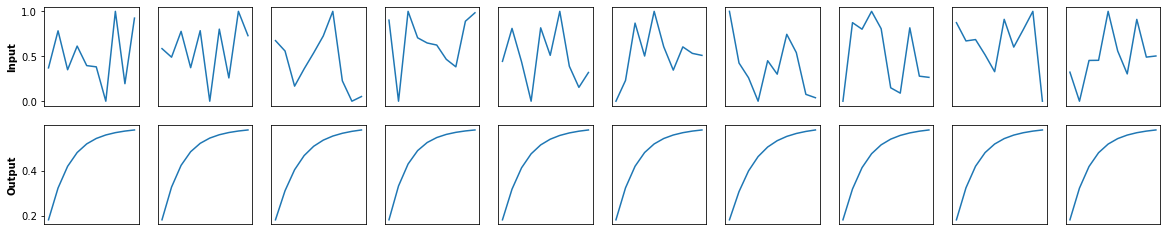

In [13]:
plot_history(history)
plot_examples(x_test, decoded_stocks)

### 8.3.4 오토인코더 모델로 새로운 특성 생성하기

In [12]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)

autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)
#############
compress_x_train = encoder.predict(x_train_simple)
compress_x_test = encoder.predict(x_test_simple)

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 25ms/step - loss: 0.7291 - val_loss: 0.7314
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.7246 - val_loss: 0.7268
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.7205 - val_loss: 0.7226
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.7168 - val_loss: 0.718

In [13]:
x_train_simple.shape  # 압축되기 전 입력 데이터는 10차원 형태

(4823, 10)

In [14]:
compress_x_train.shape  # 압축된 새로운 특성 데이터는 3차원 형태

(4823, 3)

In [15]:
compress_x_test.shape

(200, 3)

* 압축된 Feature 데이터를 데이터 프레임 형태 입력값으로 전달

In [16]:
new_feature = np.concatenate([compress_x_train,compress_x_test])
tmp_df = pd.DataFrame(new_feature,columns=['comp_fe1','comp_fe2','comp_fe3'])

In [17]:
tmp_df

,comp_fe1,comp_fe2,comp_fe3
0,0.778929,0.000000,0.951785
1,0.575979,0.010511,0.436855
2,0.736707,0.249937,0.644929
3,0.670419,1.284618,0.329520
4,0.000000,0.625541,0.000000
...,...,...,...
5018,0.594446,0.528577,0.000000
5019,0.815475,1.056431,0.497522
5020,0.944786,0.759192,0.230509
5021,0.153522,0.094993,0.496695


In [19]:
import pandas as pd
path = 'data/ch08/s&p500.csv'
snp500_df = pd.read_csv(path,usecols=['Adj Close'])
snp500_df['pct_change'] = snp500_df['Adj Close'].pct_change() # pct_change 수익률계산
snp500_df['log_ret'] = np.log(snp500_df['Adj Close']) - np.log(snp500_df['Adj Close'].shift(1)) # 로그 수익률 계산

In [20]:
snp500_df.loc[11:].reset_index(drop=True).join(tmp_df,how='left') # 과거 10일치 로그 수익률 데이터를 3차원 특성에 연결

,Adj Close,pct_change,log_ret,comp_fe1,comp_fe2,comp_fe3
0,1455.140015,-0.006832,-0.006856,0.778929,0.000000,0.951785
1,1455.900024,0.000522,0.000522,0.575979,0.010511,0.436855
2,1445.569946,-0.007095,-0.007121,0.736707,0.249937,0.644929
3,1441.359985,-0.002912,-0.002917,0.670419,1.284618,0.329520
4,1401.530029,-0.027634,-0.028023,0.000000,0.625541,0.000000
...,...,...,...,...,...,...
5018,3240.020020,0.000034,0.000034,0.594446,0.528577,0.000000
5019,3221.290039,-0.005781,-0.005798,0.815475,1.056431,0.497522
5020,3230.780029,0.002946,0.002942,0.944786,0.759192,0.230509
5021,3257.850098,0.008379,0.008344,0.153522,0.094993,0.496695


In [21]:
snp500_df.shape

(5034, 3)